# Single Cell RNA-seq Workflow for Clustering

* Preprocessing
* Quality Control
* Normalization and Imputation
* Feature Selection (HVGs)
* Dimensionality Reduction (PCA)

In [1]:
# Download data from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75688
# !wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz
# !wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE75nnn/GSE75688/suppl/GSE75688_final_sample_information.txt.gz

In [2]:
# Moving files to separate folder
# !mkdir data
# !mv GSE* data

In [3]:
# Install scanpy (only needed for Google Colab)
# !pip install --quiet scanpy

In [1]:
# Versions
!python -V

Python 3.10.4


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/mnt/wsl/PhysicalDrive6/projects/ppcic/scrnaseq/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.1 anndata==0.7.8 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.6


In [3]:
DATA_FOLDER = 'data'
RESULTS_FOLDER = 'write'

results_file = f'{RESULTS_FOLDER}/gse75688.h5ad'

# Reading Data

In [4]:
df_info = pd.read_csv(f'{DATA_FOLDER}/GSE75688_final_sample_information.txt.gz', sep='\t')
df_info

,sample,type,index,index2,index3
0,BC01_02,SC,Tumor,Tumor,Tumor
1,BC01_03,SC,Tumor,Tumor,Tumor
2,BC01_04,SC,Tumor,Tumor,Tumor
3,BC01_05,SC,Tumor,Tumor,Tumor
4,BC01_06,SC,Tumor,Tumor,Tumor
...,...,...,...,...,...
523,BC06_58,SC,nonTumor,Immune,Bcell
524,BC06_60,SC,Tumor,Tumor,Tumor
525,BC06_61,SC,nonTumor,Immune,Bcell
526,BC06_74,SC,Tumor,Tumor,Tumor


In [5]:
df_info['index'].value_counts()

Tumor       326
nonTumor    202
Name: index, dtype: int64

In [6]:
df = pd.read_csv(f'{DATA_FOLDER}/GSE75688_GEO_processed_Breast_Cancer_raw_TPM_matrix.txt.gz', sep='\t')
df

,gene_id,gene_name,gene_type,BC01_Pooled,BC01_Tumor,BC02_Pooled,BC03_Pooled,BC03LN_Pooled,BC04_Pooled,BC05_Pooled,...,BC11_04,BC11_07,BC11_28,BC11_43,BC11_56,BC11_69,BC11_70,BC11_78,BC11_81,BC11_88
0,ENSG00000000003.10,TSPAN6,protein_coding,2.33,1.25,43.96,7.64,9.32,133.37,84.77,...,0.00,47.44,16.11,0.00,6.56,0.00,0.00,0.00,200.82,0.00
1,ENSG00000000005.5,TNMD,protein_coding,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,ENSG00000000419.8,DPM1,protein_coding,60.70,28.44,74.73,41.41,87.69,120.41,70.67,...,198.96,0.00,0.00,20.63,0.00,0.00,0.00,136.07,22.03,204.58
3,ENSG00000000457.9,SCYL3,protein_coding,47.93,4.43,9.89,7.61,7.32,12.42,12.02,...,0.00,10.96,0.00,0.00,0.00,0.27,0.00,0.07,0.19,9.52
4,ENSG00000000460.12,C1orf112,protein_coding,4.79,1.67,10.87,0.92,15.13,17.10,5.69,...,0.00,6.97,9.02,0.00,0.00,0.14,247.69,22.60,11.35,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57910,ERCC-00170,ERCC-00170,ERCC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57911,ERCC-00171,ERCC-00171,ERCC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57912,SPIKE1,EC2,SPIKE_IN,14940.70,45728.19,10442.91,94250.71,40823.13,24540.58,12613.85,...,166346.51,54443.35,120842.89,135291.06,138048.60,58840.26,65246.34,33465.11,108901.35,57492.01
57913,SPIKE2,EC15,SPIKE_IN,985.82,607.50,362.55,2949.35,1291.13,854.53,399.57,...,6860.84,2136.69,4048.09,4062.59,4147.05,2286.91,2821.49,1652.19,3439.53,1837.41


## Preparing Annotated Data

### Gene Expression Matrix

In [7]:
samples = df.loc[:,'BC01_02':]
samples

,BC01_02,BC01_03,BC01_04,BC01_05,BC01_06,BC01_08,BC01_10,BC01_11,BC01_12,BC01_24,...,BC11_04,BC11_07,BC11_28,BC11_43,BC11_56,BC11_69,BC11_70,BC11_78,BC11_81,BC11_88
0,0.00,0.00,0.00,0.00,0.00,19.38,0.00,0.00,0.00,0.00,...,0.00,47.44,16.11,0.00,6.56,0.00,0.00,0.00,200.82,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,50.73,120.46,6.97,180.85,32.09,140.00,38.06,0.00,10.77,0.00,...,198.96,0.00,0.00,20.63,0.00,0.00,0.00,136.07,22.03,204.58
3,3.28,0.81,92.23,6.44,59.78,37.75,117.92,0.00,0.00,0.00,...,0.00,10.96,0.00,0.00,0.00,0.27,0.00,0.07,0.19,9.52
4,0.00,13.42,0.34,0.26,0.00,0.00,0.67,0.00,0.00,0.00,...,0.00,6.97,9.02,0.00,0.00,0.14,247.69,22.60,11.35,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57910,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57911,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
57912,18414.34,19603.44,28523.94,31210.57,48684.49,26428.35,36442.08,122515.89,57692.19,112417.31,...,166346.51,54443.35,120842.89,135291.06,138048.60,58840.26,65246.34,33465.11,108901.35,57492.01
57913,537.11,653.27,916.42,961.37,2052.48,1056.75,1802.41,4791.14,2292.81,3568.05,...,6860.84,2136.69,4048.09,4062.59,4147.05,2286.91,2821.49,1652.19,3439.53,1837.41


In [8]:
columns = samples.T.columns.values
gene_name_list = list(df['gene_name'])
columns_mapping = dict(zip(columns, gene_name_list))
samples = samples.T.rename(columns=columns_mapping)
samples

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,ERCC-00162,ERCC-00163,ERCC-00164,ERCC-00165,ERCC-00168,ERCC-00170,ERCC-00171,EC2,EC15,EC18
BC01_02,0.00,0.0,50.73,3.28,0.00,0.0,0.00,9.64,2.87,0.77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18414.34,537.11,0.0
BC01_03,0.00,0.0,120.46,0.81,13.42,0.0,0.00,36.36,5.02,1.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19603.44,653.27,0.0
BC01_04,0.00,0.0,6.97,92.23,0.34,0.0,0.00,0.00,108.11,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28523.94,916.42,0.0
BC01_05,0.00,0.0,180.85,6.44,0.26,0.0,0.00,0.00,2.32,0.37,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31210.57,961.37,0.0
BC01_06,0.00,0.0,32.09,59.78,0.00,0.0,0.33,8.42,52.59,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48684.49,2052.48,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC11_69,0.00,0.0,0.00,0.27,0.14,0.0,0.00,7.06,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58840.26,2286.91,0.0
BC11_70,0.00,0.0,0.00,0.00,247.69,0.0,0.81,4.49,0.00,53.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65246.34,2821.49,0.0
BC11_78,0.00,0.0,136.07,0.07,22.60,0.0,0.83,0.82,70.26,0.96,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33465.11,1652.19,0.0
BC11_81,200.82,0.0,22.03,0.19,11.35,0.0,0.00,4.32,1.12,6.15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,108901.35,3439.53,0.0


### Cells Metadata

In [9]:
columns_mapping = {
    'index': 'is_tumor',
    'index2': 'system',
    'index3': 'cell_type'
}
cells_metadata = df_info[df_info['type'] == 'SC']
cells_metadata = cells_metadata.rename(columns=columns_mapping)
cells_metadata

,sample,type,is_tumor,system,cell_type
0,BC01_02,SC,Tumor,Tumor,Tumor
1,BC01_03,SC,Tumor,Tumor,Tumor
2,BC01_04,SC,Tumor,Tumor,Tumor
3,BC01_05,SC,Tumor,Tumor,Tumor
4,BC01_06,SC,Tumor,Tumor,Tumor
...,...,...,...,...,...
522,BC06_43,SC,nonTumor,Stromal,Stromal
523,BC06_58,SC,nonTumor,Immune,Bcell
524,BC06_60,SC,Tumor,Tumor,Tumor
525,BC06_61,SC,nonTumor,Immune,Bcell


In [10]:
sample_names = list(samples.index.values)
labeled = list(cells_metadata['sample'].values)
unlabeled = list(cell for cell in sample_names if cell not in labeled)
print(f'Number of unlabeled samples: {len(unlabeled)}')

Number of unlabeled samples: 34


In [11]:
empty_rows = pd.DataFrame({'sample':sample_names})
empty_rows

,sample
0,BC01_02
1,BC01_03
2,BC01_04
3,BC01_05
4,BC01_06
...,...
544,BC11_69
545,BC11_70
546,BC11_78
547,BC11_81


In [12]:
cells_metadata = empty_rows.merge(cells_metadata, how='left', on='sample')
cells_metadata

,sample,type,is_tumor,system,cell_type
0,BC01_02,SC,Tumor,Tumor,Tumor
1,BC01_03,SC,Tumor,Tumor,Tumor
2,BC01_04,SC,Tumor,Tumor,Tumor
3,BC01_05,SC,Tumor,Tumor,Tumor
4,BC01_06,SC,Tumor,Tumor,Tumor
...,...,...,...,...,...
544,BC11_69,SC,Tumor,Tumor,Tumor
545,BC11_70,SC,Tumor,Tumor,Tumor
546,BC11_78,SC,Tumor,Tumor,Tumor
547,BC11_81,SC,Tumor,Tumor,Tumor


In [13]:
cells_metadata = cells_metadata.set_index(cells_metadata['sample'])
cells_metadata.head(10)

,sample,type,is_tumor,system,cell_type
sample,,,,,
BC01_02,BC01_02,SC,Tumor,Tumor,Tumor
BC01_03,BC01_03,SC,Tumor,Tumor,Tumor
BC01_04,BC01_04,SC,Tumor,Tumor,Tumor
BC01_05,BC01_05,SC,Tumor,Tumor,Tumor
BC01_06,BC01_06,SC,Tumor,Tumor,Tumor
BC01_08,BC01_08,SC,Tumor,Tumor,Tumor
BC01_10,BC01_10,SC,Tumor,Tumor,Tumor
BC01_11,BC01_11,NaN,NaN,NaN,NaN
BC01_12,BC01_12,SC,Tumor,Tumor,Tumor


### Genes Metadata

In [14]:
genes_metadata = df[['gene_id', 'gene_name', 'gene_type']].set_index('gene_name', drop=False)
genes_metadata

,gene_id,gene_name,gene_type
gene_name,,,
TSPAN6,ENSG00000000003.10,TSPAN6,protein_coding
TNMD,ENSG00000000005.5,TNMD,protein_coding
DPM1,ENSG00000000419.8,DPM1,protein_coding
SCYL3,ENSG00000000457.9,SCYL3,protein_coding
C1orf112,ENSG00000000460.12,C1orf112,protein_coding
...,...,...,...
ERCC-00170,ERCC-00170,ERCC-00170,ERCC
ERCC-00171,ERCC-00171,ERCC-00171,ERCC
EC2,SPIKE1,EC2,SPIKE_IN


In [15]:
print(samples.shape)
print(cells_metadata.shape)
print(genes_metadata.shape)

(549, 57915)
(549, 5)
(57915, 3)


In [16]:
adata = ad.AnnData(samples, obs=cells_metadata, var=genes_metadata)
#adata = ad.AnnData(samples)
adata

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 549 × 57915
    obs: 'sample', 'type', 'is_tumor', 'system', 'cell_type'
    var: 'gene_id', 'gene_name', 'gene_type'

In [17]:
adata.var_names

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'ERCC-00162', 'ERCC-00163', 'ERCC-00164', 'ERCC-00165', 'ERCC-00168',
       'ERCC-00170', 'ERCC-00171', 'EC2', 'EC15', 'EC18'],
      dtype='object', name='gene_name', length=57915)

In [18]:
adata.obs_names

Index(['BC01_02', 'BC01_03', 'BC01_04', 'BC01_05', 'BC01_06', 'BC01_08',
       'BC01_10', 'BC01_11', 'BC01_12', 'BC01_24',
       ...
       'BC11_04', 'BC11_07', 'BC11_28', 'BC11_43', 'BC11_56', 'BC11_69',
       'BC11_70', 'BC11_78', 'BC11_81', 'BC11_88'],
      dtype='object', name='sample', length=549)

In [19]:
adata.var_names_make_unique()

/mnt/wsl/PhysicalDrive6/projects/ppcic/scrnaseq/venv/lib/python3.10/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD113-1', 'SNORD113-2', 'SNORD113-3', 'SNORD113-4', 'SNORD113-5']
  warnings.warn(


In [20]:
adata.X

array([[0.0000000e+00, 0.0000000e+00, 5.0730000e+01, ..., 1.8414340e+04,
        5.3710999e+02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.2046000e+02, ..., 1.9603439e+04,
        6.5327002e+02, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 6.9699998e+00, ..., 2.8523939e+04,
        9.1641998e+02, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 1.3607001e+02, ..., 3.3465109e+04,
        1.6521899e+03, 0.0000000e+00],
       [2.0082001e+02, 0.0000000e+00, 2.2030001e+01, ..., 1.0890135e+05,
        3.4395300e+03, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 2.0458000e+02, ..., 5.7492012e+04,
        1.8374100e+03, 0.0000000e+00]], dtype=float32)

In [21]:
adata.var

,gene_id,gene_name,gene_type
gene_name,,,
TSPAN6,ENSG00000000003.10,TSPAN6,protein_coding
TNMD,ENSG00000000005.5,TNMD,protein_coding
DPM1,ENSG00000000419.8,DPM1,protein_coding
SCYL3,ENSG00000000457.9,SCYL3,protein_coding
C1orf112,ENSG00000000460.12,C1orf112,protein_coding
...,...,...,...
ERCC-00170,ERCC-00170,ERCC-00170,ERCC
ERCC-00171,ERCC-00171,ERCC-00171,ERCC
EC2,SPIKE1,EC2,SPIKE_IN


In [22]:
adata.obs

,sample,type,is_tumor,system,cell_type
sample,,,,,
BC01_02,BC01_02,SC,Tumor,Tumor,Tumor
BC01_03,BC01_03,SC,Tumor,Tumor,Tumor
BC01_04,BC01_04,SC,Tumor,Tumor,Tumor
BC01_05,BC01_05,SC,Tumor,Tumor,Tumor
BC01_06,BC01_06,SC,Tumor,Tumor,Tumor
...,...,...,...,...,...
BC11_69,BC11_69,SC,Tumor,Tumor,Tumor
BC11_70,BC11_70,SC,Tumor,Tumor,Tumor
BC11_78,BC11_78,SC,Tumor,Tumor,Tumor


# Preprocessing

normalizing counts per cell
    finished (0:00:00)


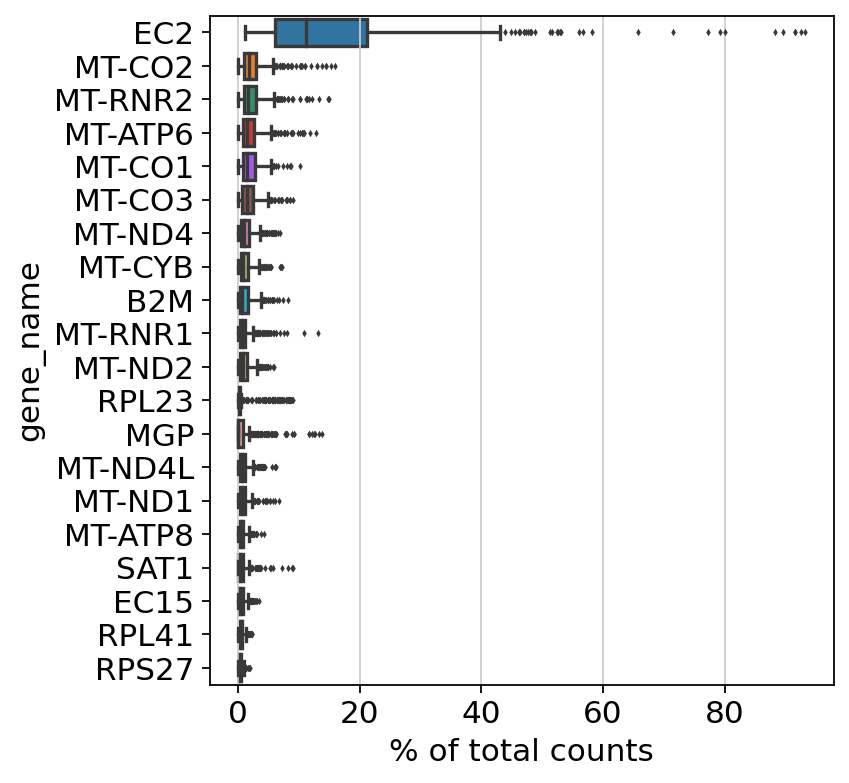

In [23]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [24]:
# Filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 29881 genes that are detected in less than 3 cells


In [25]:
# QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/mnt/wsl/PhysicalDrive6/projects/ppcic/scrnaseq/venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'type' as categorical
/mnt/wsl/PhysicalDrive6/projects/ppcic/scrnaseq/venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'is_tumor' as categorical
/mnt/wsl/PhysicalDrive6/projects/ppcic/scrnaseq/venv/lib/python3.10/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.

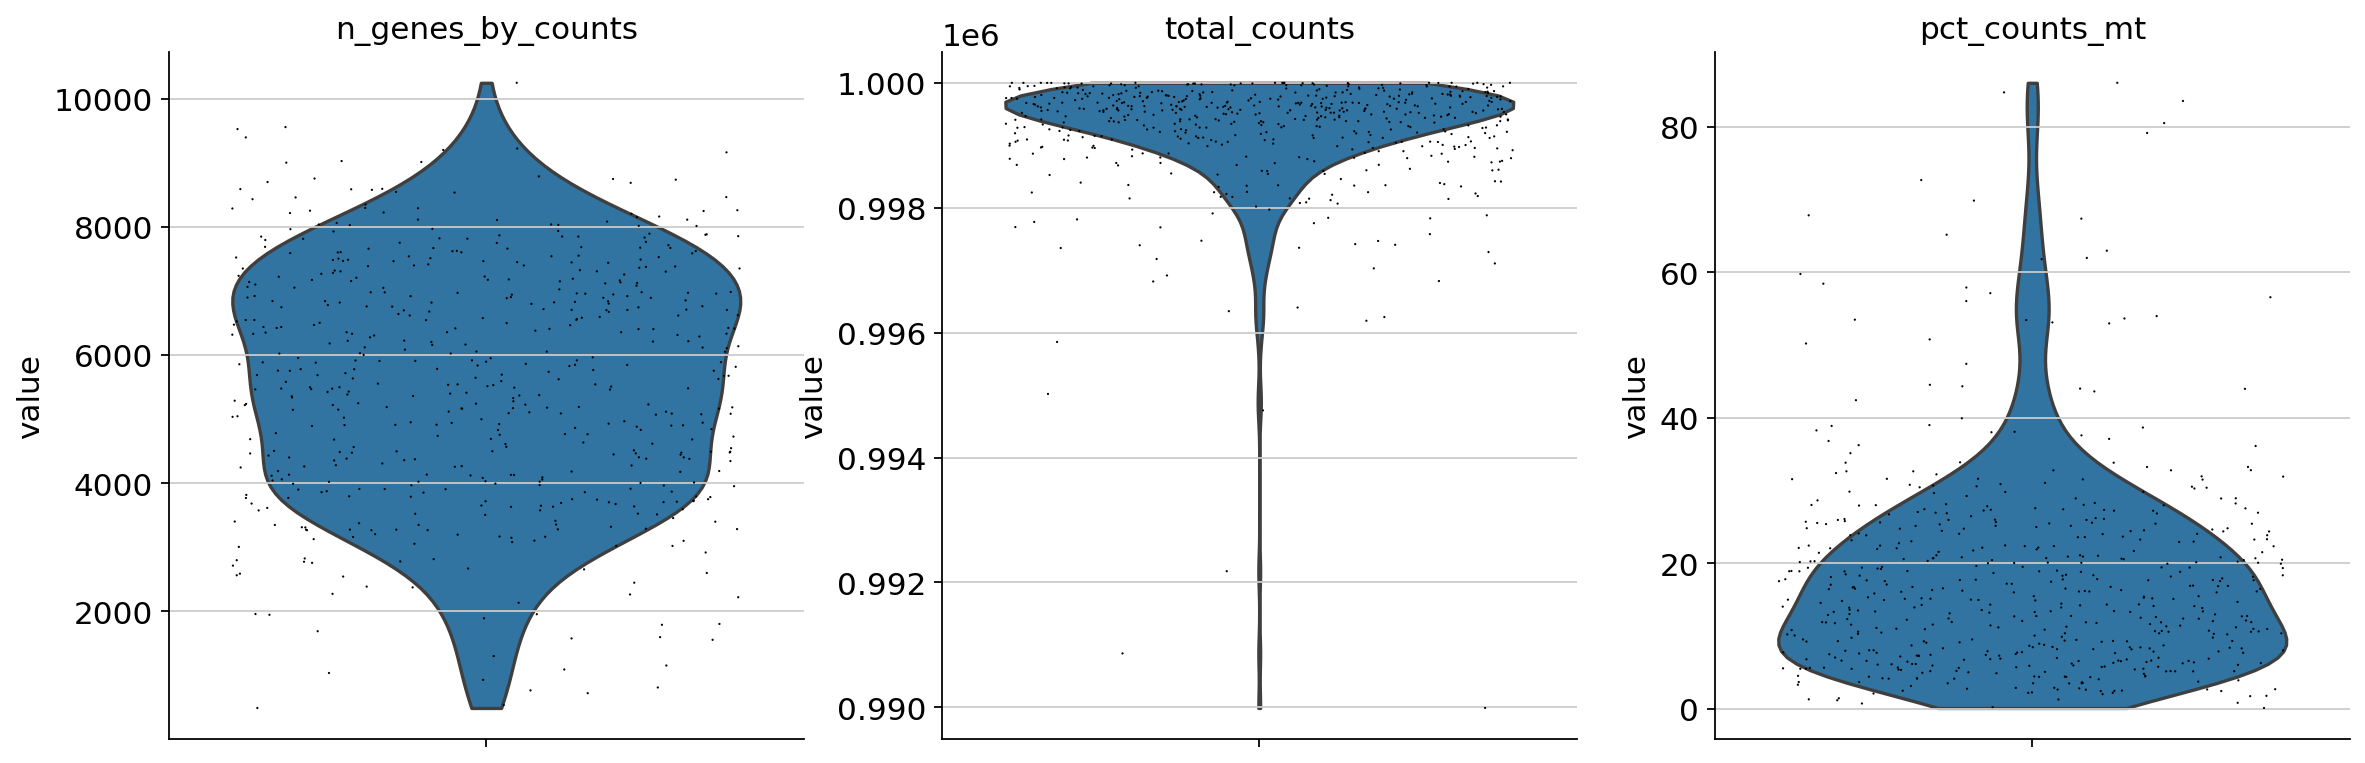

In [26]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

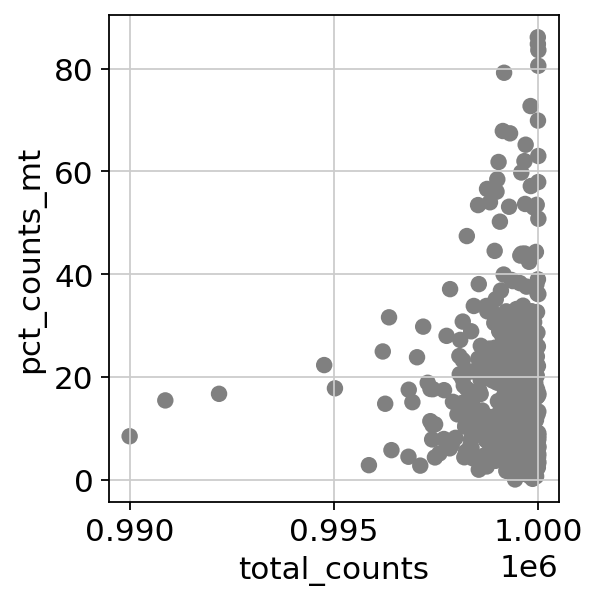

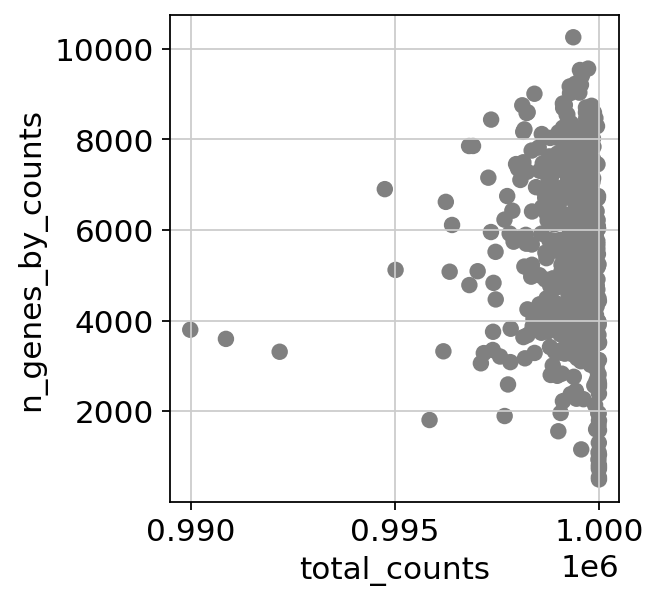

In [27]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [28]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [29]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/mnt/wsl/PhysicalDrive6/projects/ppcic/scrnaseq/venv/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [30]:
sc.pp.log1p(adata)

In [31]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


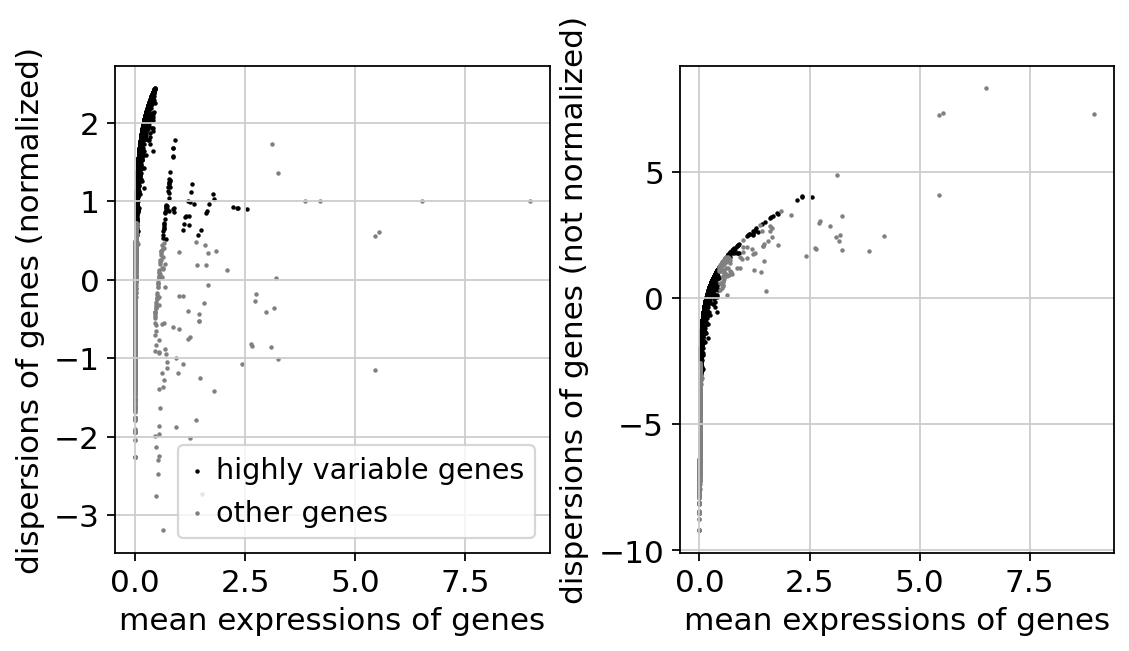

In [32]:
sc.pl.highly_variable_genes(adata)

In [33]:
adata.raw = adata

In [34]:
adata = adata[:, adata.var.highly_variable]

In [35]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:02)


In [36]:
sc.pp.scale(adata, max_value=10)

In [37]:
dir(adata)

['T',
 'X',
 '_BACKED_ATTRS',
 '_H5_ALIASES',
 '_H5_ALIASES_NAMES',
 '_X',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adata_ref',
 '_check_dimensions',
 '_check_uniqueness',
 '_clean_up_old_format',
 '_gen_repr',
 '_get_X',
 '_get_and_delete_multicol_field',
 '_get_obs_array',
 '_get_var_array',
 '_init_as_actual',
 '_init_as_view',
 '_inplace_subset_obs',
 '_inplace_subset_var',
 '_is_view',
 '_layers',
 '_mutated_copy',
 '_n_obs',
 '_n_vars',
 '_normalize_indices',
 '_obs',
 '_obsm',
 '_obsp',
 '_oidx',
 '_prep_dim_index',
 '_raw',
 '_remove_unused_categories',
 '_sanitize',
 '_set_ba

In [38]:
adata.T.obs

,gene_id,gene_name,gene_type,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm,mean,std
gene_name,,,,,,,,,,,,,,,
LAS1L,ENSG00000001497.12,LAS1L,protein_coding,250,False,250,14.991441,54.462659,8230.300781,True,0.014018,-2.468629,0.778202,-1.940255e-10,0.020016
LAP3,ENSG00000002549.8,LAP3,protein_coding,410,False,410,92.391418,25.318761,50722.890625,True,0.196546,-1.606385,1.166228,1.050163e-09,0.123848
HS3ST1,ENSG00000002587.5,HS3ST1,protein_coding,52,False,52,0.502331,90.528233,275.779999,True,0.037497,-1.472937,1.226282,-8.246085e-11,0.006585
RBM5,ENSG00000003756.12,RBM5,protein_coding,423,False,423,106.024315,22.950820,58207.347656,True,0.018194,-2.262711,0.870869,-4.268562e-10,0.035337
FKBP4,ENSG00000004478.5,FKBP4,protein_coding,370,False,370,40.346989,32.604736,22150.496094,True,0.024416,-1.908518,1.030262,5.432715e-10,0.054393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RP11-500M8.7,ENSG00000272921.1,RP11-500M8.7,protein_coding,300,False,300,29.196821,45.355191,16029.054688,True,0.135840,-0.135828,1.828007,3.104409e-10,0.215645
CTD-2303H24.2,ENSG00000273018.1,CTD-2303H24.2,processed_transcript,94,False,94,7.688853,82.877960,4221.180176,True,0.015423,-2.372443,0.821487,3.880511e-10,0.030638
RP11-290D2.6,ENSG00000273149.1,RP11-290D2.6,antisense,55,False,55,1.263406,89.981785,693.609985,True,0.061059,-0.973476,1.451049,-9.701277e-11,0.010224


In [39]:
type(adata.X)

numpy.ndarray

In [40]:
np.min(adata.X)

-1.9265158

In [41]:
np.max(adata.X)

1.9667239

## PCA

In [42]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=5
    finished (0:00:00)


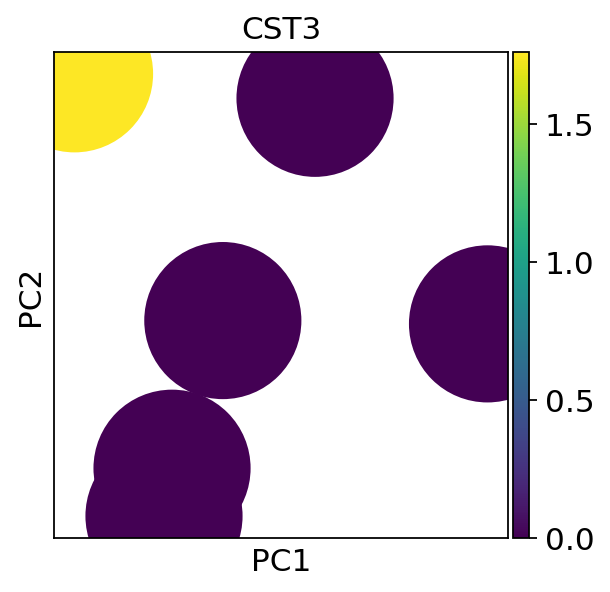

In [43]:
sc.pl.pca(adata, color='CST3')

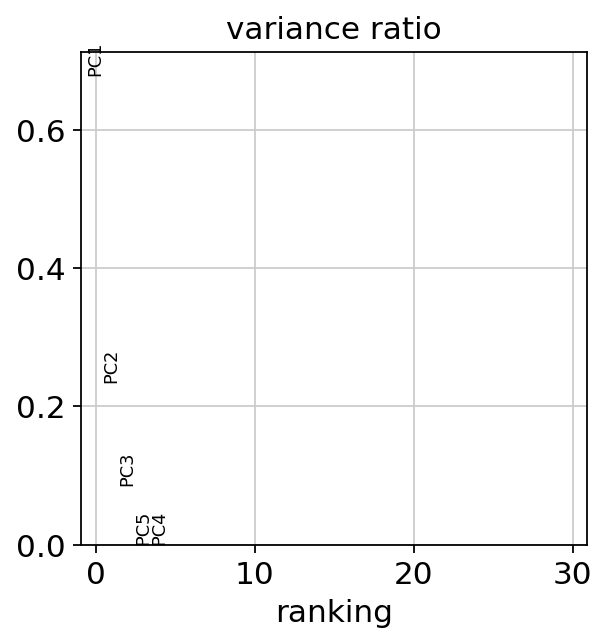

In [44]:
# TODO - This is where the error occurs
sc.pl.pca_variance_ratio(adata, log=False)

In [45]:
results_file

'write/gse75688.h5ad'

In [46]:
# Saving results
adata.write(results_file)

ValueError: Unable to create dataset (name already exists)

Above error raised while writing key 'gene_name' of <class 'h5py._hl.group.Group'> from /.

Above error raised while writing key 'gene_name' of <class 'h5py._hl.group.Group'> from /.

Above error raised while writing key 'raw/var' of <class 'h5py._hl.files.File'> from /.

In [ ]:
adata

## Computing Neighborhood Graph

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=4)

In [ ]:
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

In [ ]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

### Clustering the neighborhood graph

In [ ]:
sc.tl.leiden(adata)

In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

In [ ]:
adata.write(results_file)

## Filtering marker genes

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.write(results_file)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
adata = sc.read(results_file)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
adata = sc.read(results_file)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [ ]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

In [ ]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [ ]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

In [ ]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

In [ ]:
adata

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

In [ ]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

In [ ]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )